In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scip_workflows.common import *


In [3]:
import pickle
import shap
import sklearn.base
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import spearmanr
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFECV, SelectFromModel
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    RobustScaler,
    MinMaxScaler,
    StandardScaler,
    PowerTransformer
)
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier


In [4]:
plt.rcParams["figure.dpi"] = 200


## Data import

In [5]:
try:
    features = snakemake.input.features
    index = snakemake.input.index
    columns = snakemake.input.columns
    labels = snakemake.input.labels
except NameError:
    data_root = Path("/home/maximl/scratch/data/vsc/datasets/wbc/")
    # data_root = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"
    data_scip = data_root / "scip/20220713131400/"
    features = data_scip / "WBC_features.parquet"
    index = data_scip / "indices/index.npy"
    columns = data_scip / "indices/columns.npy"
    labels = data_scip / "labels.parquet"

In [6]:
df = pq.read_table(features).to_pandas()

df = df[numpy.load(columns, allow_pickle=True)]
df = df.loc[numpy.load(index, allow_pickle=True)]

labels = pq.read_table(labels).to_pandas()
df = df.merge(labels, left_index=True, right_index=True)
# df["meta_label"] = pandas.Categorical(df["meta_label"], ordered=True)

df.shape


(218404, 3923)

In [7]:
# df = df.drop(0, level="meta_group")

In [8]:
df = df.loc[df["meta_label"] != "unknown"].copy()
df["meta_label"] = df["meta_label"].cat.remove_unused_categories()
enc = LabelEncoder().fit(df["meta_label"])

In [9]:
from sklearn.model_selection import PredefinedSplit

test_fold_outer = df.index.to_frame().apply(
    lambda x: 0 if (x["meta_group"] == 2) and (x["meta_fix"] == "early") else -1,
    axis="columns"
).values 
outer_cv = PredefinedSplit(test_fold_outer)

sel = pandas.Series([True]*df.shape[0], index=df.index)
sel.loc[2, :, 'early'] = False
inner_index = df[sel].index.to_frame(index=False)
unique_combos = inner_index.set_index(['meta_group','meta_fix']).index.unique()
test_fold_inner = inner_index.apply(lambda x: unique_combos.get_loc((x.meta_group, x.meta_fix)), axis="columns")
inner_cv = PredefinedSplit(test_fold_inner)
# inner_cv = 5

In [10]:
from scip.features import shape, intensity
import re

def map_to_feature(a):
    pattern = r"^(feat|meta)_(?P<mask>[^_]+)_(?P<combined>combined)?_?(?P<bgcorr>bgcorr)?_?(?P<edge>edge)?_?(?P<feature>.+)_(?P<channel>.+)$"
    return re.match(pattern, a).groupdict()["feature"]

In [11]:
transformer_robust = make_column_transformer(
    (
        RobustScaler(quantile_range=(5,95)),
        make_column_selector(
            pattern=".*(glcm|sobel|%s).*" % "|".join(intensity.props)
        )
    ),
    (
        MinMaxScaler(), 
        make_column_selector(
            pattern=".*(%s).*" % "|".join(shape.prop_names)
        )
    ), 
    remainder="passthrough"
).set_output(transform="pandas")

transformer_standard = make_column_transformer(
    (
        StandardScaler(),
        make_column_selector(
            pattern=".*(glcm|sobel|%s).*" % "|".join(intensity.props)
        )
    ),
    (
        MinMaxScaler(), 
        make_column_selector(
            pattern=".*(%s).*" % "|".join(shape.prop_names)
        )
    ), 
    remainder="passthrough"
).set_output(transform="pandas")

transformer_power = make_column_transformer(
    (
        PowerTransformer(),
        make_column_selector(
            pattern=".*(glcm|sobel|%s).*" % "|".join(intensity.props)
        )
    ),
    (
        MinMaxScaler(), 
        make_column_selector(
            pattern=".*(%s).*" % "|".join(shape.prop_names)
        )
    ), 
    remainder="passthrough"
).set_output(transform="pandas")

In [12]:
df["meta_batch"] = (
    df.index.get_level_values("meta_group").astype(str) +
    df.index.get_level_values("meta_fix").astype(str)
)

In [13]:
X = df.filter(regex=".*_li_.*(BF1|BF2|SSC)$")
X_robust_mm = X.groupby(df["meta_batch"], group_keys=False).apply(lambda gdf: transformer_robust.fit_transform(gdf))
X_standard_mm = X.groupby(df["meta_batch"], group_keys=False).apply(lambda gdf: transformer_standard.fit_transform(gdf))
X_power_mm = X.groupby(df["meta_batch"], group_keys=False).apply(lambda gdf: transformer_power.fit_transform(gdf))
X_robust = X.groupby(df["meta_batch"], group_keys=False).apply(
    lambda gdf: RobustScaler().set_output(transform="pandas").fit_transform(gdf))
X_standard = X.groupby(df["meta_batch"], group_keys=False).apply(
    lambda gdf: StandardScaler().set_output(transform="pandas").fit_transform(gdf))

y = enc.transform(df["meta_label"])

outer_train, _ = next(outer_cv.split(X, y))

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
This pattern is interpreted as a regular

In [14]:
def results_for_pipeline(pipeline, X, y):
    return cross_validate(
        estimator=pipeline,
        cv=inner_cv,
        X=X,
        y=y,
        return_estimator=True,
        return_train_score=True,
        error_score="raise",
        scoring=('balanced_accuracy', 'f1_macro', 'precision_macro', 'recall_macro'),
        n_jobs=inner_cv.get_n_splits(X, y)
    )
    

In [15]:
results = {}

In [16]:
pipeline = SGDClassifier(random_state=0)

results["sgd_noscale"] = results_for_pipeline(pipeline, X.iloc[outer_train], y[outer_train])
results["sgd_standard"] = results_for_pipeline(pipeline, X_standard.iloc[outer_train], y[outer_train])
results["sgd_robust"] = results_for_pipeline(pipeline, X_robust.iloc[outer_train], y[outer_train])
results["sgd_standard_mm"] = results_for_pipeline(pipeline, X_standard_mm.iloc[outer_train], y[outer_train])
results["sgd_robust_mm"] = results_for_pipeline(pipeline, X_robust_mm.iloc[outer_train], y[outer_train])

/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/scrat

In [17]:
pipeline = XGBClassifier(
    booster="gbtree",
    objective="multi:softmax",
    eval_metric="merror",
    tree_method="gpu_hist",
    use_label_encoder=False,
    random_state=0,
    n_jobs=1,
    gpu_id=6,
    n_estimators=640,
    subsample=.7,
    min_child_weight=20,
    max_depth=6,
    gamma=26
)

results["xgb_noscale"] = results_for_pipeline(pipeline, X.iloc[outer_train], y[outer_train])
results["xgb_standard"] = results_for_pipeline(pipeline, X_standard.iloc[outer_train], y[outer_train])
results["xgb_robust"] = results_for_pipeline(pipeline, X_robust.iloc[outer_train], y[outer_train])
results["xgb_standard_mm"] = results_for_pipeline(pipeline, X_standard_mm.iloc[outer_train], y[outer_train])
results["xgb_robust_mm"] = results_for_pipeline(pipeline, X_robust_mm.iloc[outer_train], y[outer_train])

[12:14:13] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[12:14:13] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:14:13] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:14:14] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/scrat

In [18]:
results["xgb_power_mm"] = results_for_pipeline(pipeline, X_power_mm.iloc[outer_train], y[outer_train])

/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: xlabel='value', ylabel='key'>

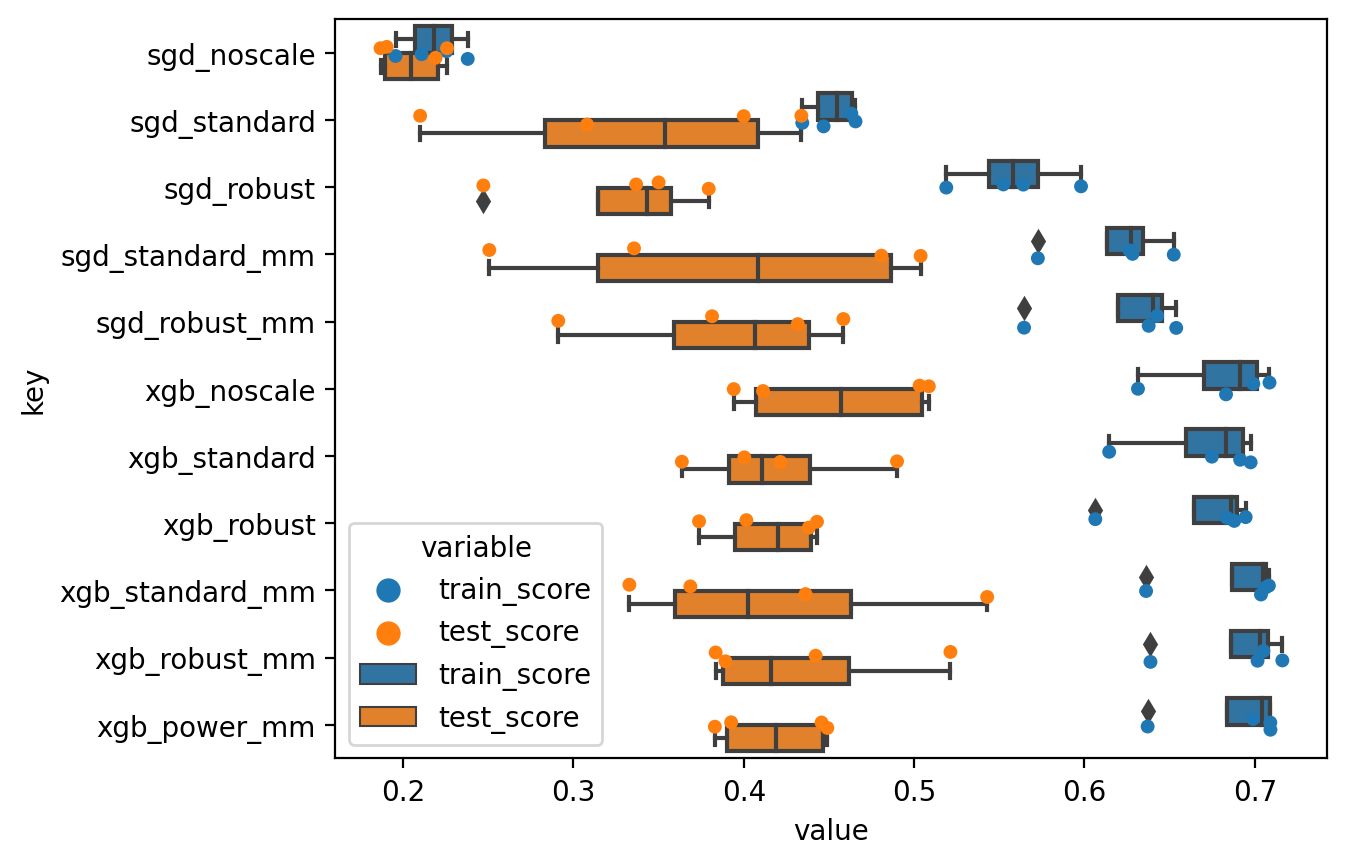

In [19]:
data = []
for k,v in results.items():
    for i, (train_score, test_score) in enumerate(zip(v["train_balanced_accuracy"], v["test_balanced_accuracy"])):
        data.append(dict(key=k, train_score=train_score, test_score=test_score, fold=i))
results_df = pandas.DataFrame(data=data)

seaborn.stripplot(
    data=pandas.melt(results_df, id_vars=["key", "fold"]),
    y="key",
    x="value",
    hue="variable"
)
seaborn.boxplot(
    data=pandas.melt(results_df, id_vars=["key", "fold"]),
    y="key",
    x="value",
    hue="variable"
)

In [20]:
results_df.drop(columns="fold").groupby(["key"]).mean()["test_score"].idxmax()

'xgb_noscale'

[12:15:49] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:17:19] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:18:51] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:20:21] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:21:54] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:15:49] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:17:20] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:18:51] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:20:21] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:21:54] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:15:49] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[12:17:21]

In [48]:
X_ = X_robust_mm.iloc[outer_train]
y_ = y[outer_train]

In [109]:
pipeline = imb_make_pipeline(
    RandomUnderSampler(sampling_strategy="majority", random_state=0),
    RandomOverSampler(sampling_strategy="not majority", random_state=0), 
    XGBClassifier(
        booster="gbtree",
        objective="multi:softmax",
        eval_metric="merror",
        tree_method="gpu_hist",
        use_label_encoder=False,
        random_state=0,
        n_jobs=1,
        gpu_id=6,
        n_estimators=100,
    )
)

results["xgb+sampling"] = results_for_pipeline(pipeline, X_, y_)

[17:24:04] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[17:24:36] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[17:25:07] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[17:25:41] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


In [110]:
pipeline = imb_make_pipeline(
    RandomUnderSampler(sampling_strategy="majority", random_state=0),
    RandomOverSampler(sampling_strategy="not majority", random_state=0), 
    make_column_transformer(
        (
            RobustScaler(quantile_range=(5,95)),
            make_column_selector(
                pattern=".*(glcm|sobel|%s).*" % "|".join(intensity.props)
            )
        ),
        (
            MinMaxScaler(), 
            make_column_selector(
                pattern=".*(%s).*" % "|".join(shape.prop_names)
            )
        ), 
        remainder="passthrough"
    ),
    XGBClassifier(
        booster="gbtree",
        objective="multi:softmax",
        eval_metric="merror",
        tree_method="gpu_hist",
        use_label_encoder=False,
        random_state=0,
        n_jobs=1,
        gpu_id=6,
        n_estimators=100,
    )
)

results["xgb+sampling+scaling"] = results_for_pipeline(pipeline, X_, y_)

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:26:26] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:27:13] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:28:00] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:28:51] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


In [111]:
pipeline = imb_make_pipeline(
    RandomUnderSampler(sampling_strategy="majority", random_state=0),
    RandomOverSampler(sampling_strategy="not majority", random_state=0), 
    make_column_transformer(
        (
            RobustScaler(quantile_range=(5,95)),
            make_column_selector(
                pattern=".*(glcm|sobel|%s).*" % "|".join(intensity.props)
            )
        ),
        (
            MinMaxScaler(), 
            make_column_selector(
                pattern=".*(%s).*" % "|".join(shape.prop_names)
            )
        ), 
        remainder="passthrough"
    ),
    VarianceThreshold(threshold=1e-5),
    SelectFromModel(SGDClassifier(random_state=0, max_iter=100)),
    XGBClassifier(
        booster="gbtree",
        objective="multi:softmax",
        eval_metric="merror",
        tree_method="gpu_hist",
        use_label_encoder=False,
        random_state=0,
        n_jobs=1,
        gpu_id=6,
        n_estimators=100,
    )
)

results["xgb+sampling+scaling+select"] = results_for_pipeline(pipeline, X_, y_)

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:30:48] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:32:15] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:33:49] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:35:45] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


In [112]:
pipeline = imb_make_pipeline(
    RandomUnderSampler(sampling_strategy="majority", random_state=0),
    RandomOverSampler(sampling_strategy="not majority", random_state=0), 
    make_column_transformer(
        (
            RobustScaler(quantile_range=(5,95)),
            make_column_selector(
                pattern=".*(glcm|sobel|%s).*" % "|".join(intensity.props)
            )
        ),
        (
            MinMaxScaler(), 
            make_column_selector(
                pattern=".*(%s).*" % "|".join(shape.prop_names)
            )
        ), 
        remainder="passthrough"
    ),
    PCA(random_state=0, n_components=.95),
    XGBClassifier(
        booster="gbtree",
        objective="multi:softmax",
        eval_metric="merror",
        tree_method="gpu_hist",
        use_label_encoder=False,
        random_state=0,
        n_jobs=1,
        gpu_id=6,
        n_estimators=100,
    )
)

results["xgb+sampling+scaling+pca"] = results_for_pipeline(pipeline, X_, y_)

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:36:48] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:37:35] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:38:23] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[17:39:27] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


In [21]:
# pipeline = imb_make_pipeline(
#     RandomUnderSampler(sampling_strategy="majority", random_state=0),
#     RandomOverSampler(sampling_strategy="not majority", random_state=0), 
#     XGBClassifier(
#         booster="gbtree",
#         objective="multi:softmax",
#         eval_metric="merror",
#         tree_method="gpu_hist",
#         use_label_encoder=False,
#         random_state=0,
#         n_jobs=1,
#         gpu_id=6,
#         n_estimators=100,
#     )
# )

# weights = {
#     'CD15 + Neutrophils': 1, 
#     'NK T cells': 10, 
#     'Eosinophils': 10, 
#     'CD4 T cells': 10, 
#     'CD56+ NK Cells': 10, 
#     'CD14+ Monocyte': 1, 
#     'CD8 T cell': 10, 
#     'CD19 pos B cells': 10
# }
# sample_weight = df.iloc[outer_train]["meta_label"].map(lambda x: weights[x]).values

# results["xgb+sampling+weights"] = results_for_pipeline(
#     pipeline, X_, y_, 
#     fit_params = dict(xgbclassifier__sample_weight=sample_weight)
# )

In [113]:
data = []
for k,v in results.items():
    for i, (train_score, test_score) in enumerate(zip(v["train_balanced_accuracy"], v["test_balanced_accuracy"])):
        data.append(dict(key=k, train_score=train_score, test_score=test_score, fold=i))
results_df = pandas.DataFrame(data=data)

<Axes: xlabel='value', ylabel='key'>

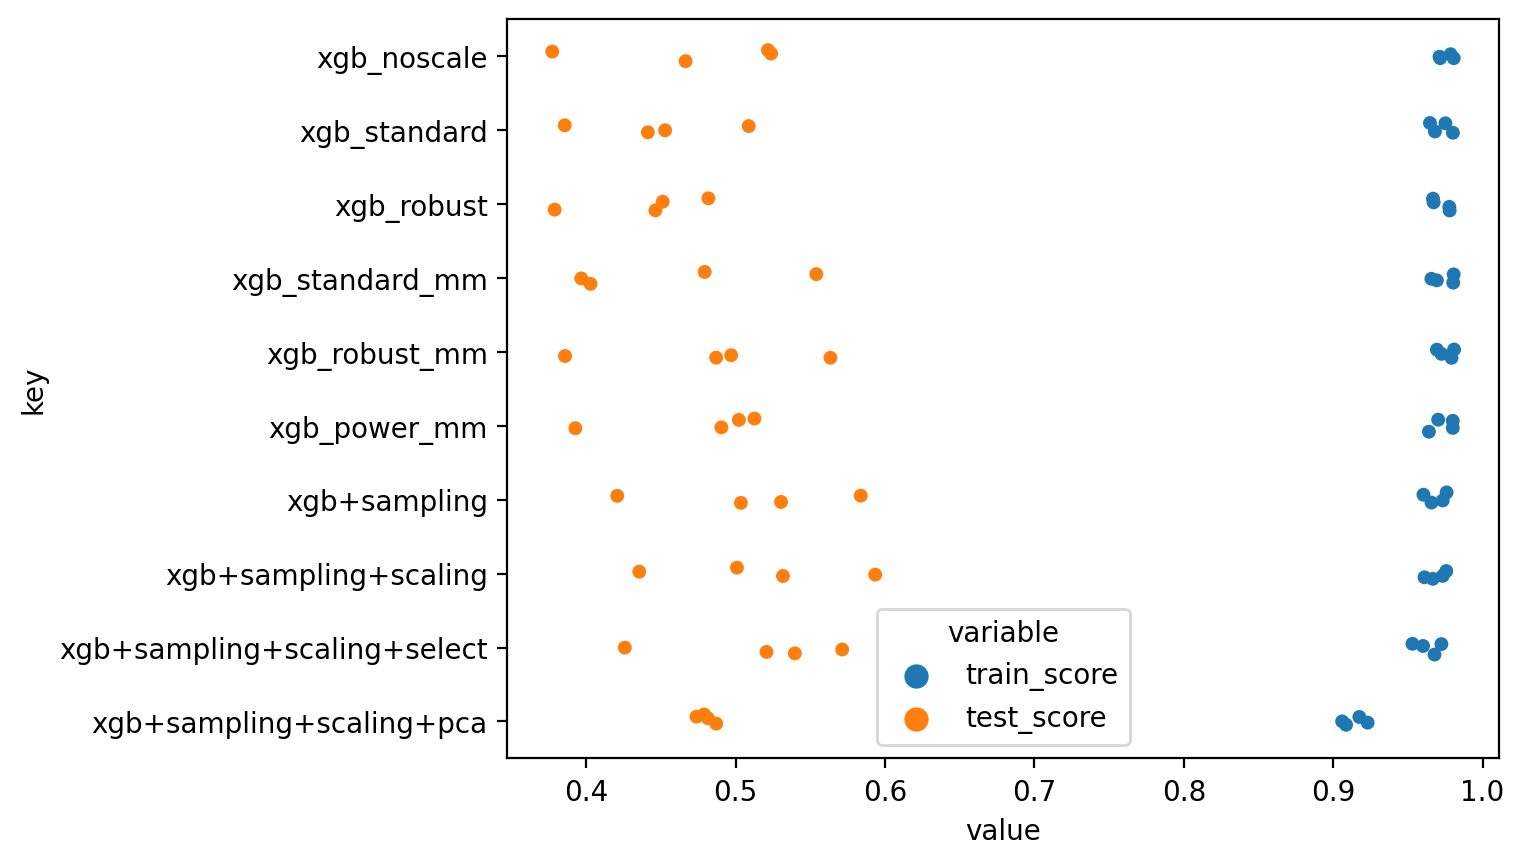

In [114]:
seaborn.stripplot(
    data=pandas.melt(results_df, id_vars=["key", "fold"]),
    y="key",
    x="value",
    hue="variable"
)

In [115]:
pandas.melt(results_df, id_vars=["key", "fold"]).groupby(["key", "variable"])["value"].mean()

key                          variable   
xgb+sampling                 test_score     0.509675
                             train_score    0.968882
xgb+sampling+scaling         test_score     0.515436
                             train_score    0.969205
xgb+sampling+scaling+pca     test_score     0.480365
                             train_score    0.913811
xgb+sampling+scaling+select  test_score     0.514437
                             train_score    0.963369
xgb_noscale                  test_score     0.472360
                             train_score    0.975532
xgb_power_mm                 test_score     0.474557
                             train_score    0.973618
xgb_robust                   test_score     0.439610
                             train_score    0.972438
xgb_robust_mm                test_score     0.483385
                             train_score    0.975503
xgb_standard                 test_score     0.447195
                             train_score    0.972038
xgb_s

In [50]:
from sklearn.base import clone

In [51]:
result_outer = cross_validate(
    estimator=clone(results["xgb_robust_mm"]["estimator"][0]),
    cv=outer_cv,
    X=X_robust_mm,
    y=y,
    return_estimator=True,
    return_train_score=True,
    error_score="raise",
    scoring=('balanced_accuracy', 'f1_macro', 'precision_macro', 'recall_macro'),
)

[10:38:47] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [52]:
result_outer

{'fit_time': array([9.80690193]),
 'score_time': array([0.86478114]),
 'estimator': [XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric='merror', gamma=0, gpu_id=6, grow_policy='depthwise',
                importance_type=None, interaction_constraints='',
                learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
                max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
                missing=nan, monotone_constraints='()', n_estimators=100,
                n_jobs=1, num_parallel_tree=1, objective='multi:softmax',
                predictor='auto', random_state=0, reg_alpha=0, ...)],
 'test_balanced_accuracy': array([0.41842578]),
 'train_balanced_accuracy': array([0.99982638]),
 'test_f1_macro': array([0.36936448]),
 'train_f1_macro': array([0.99984424]),
 'te

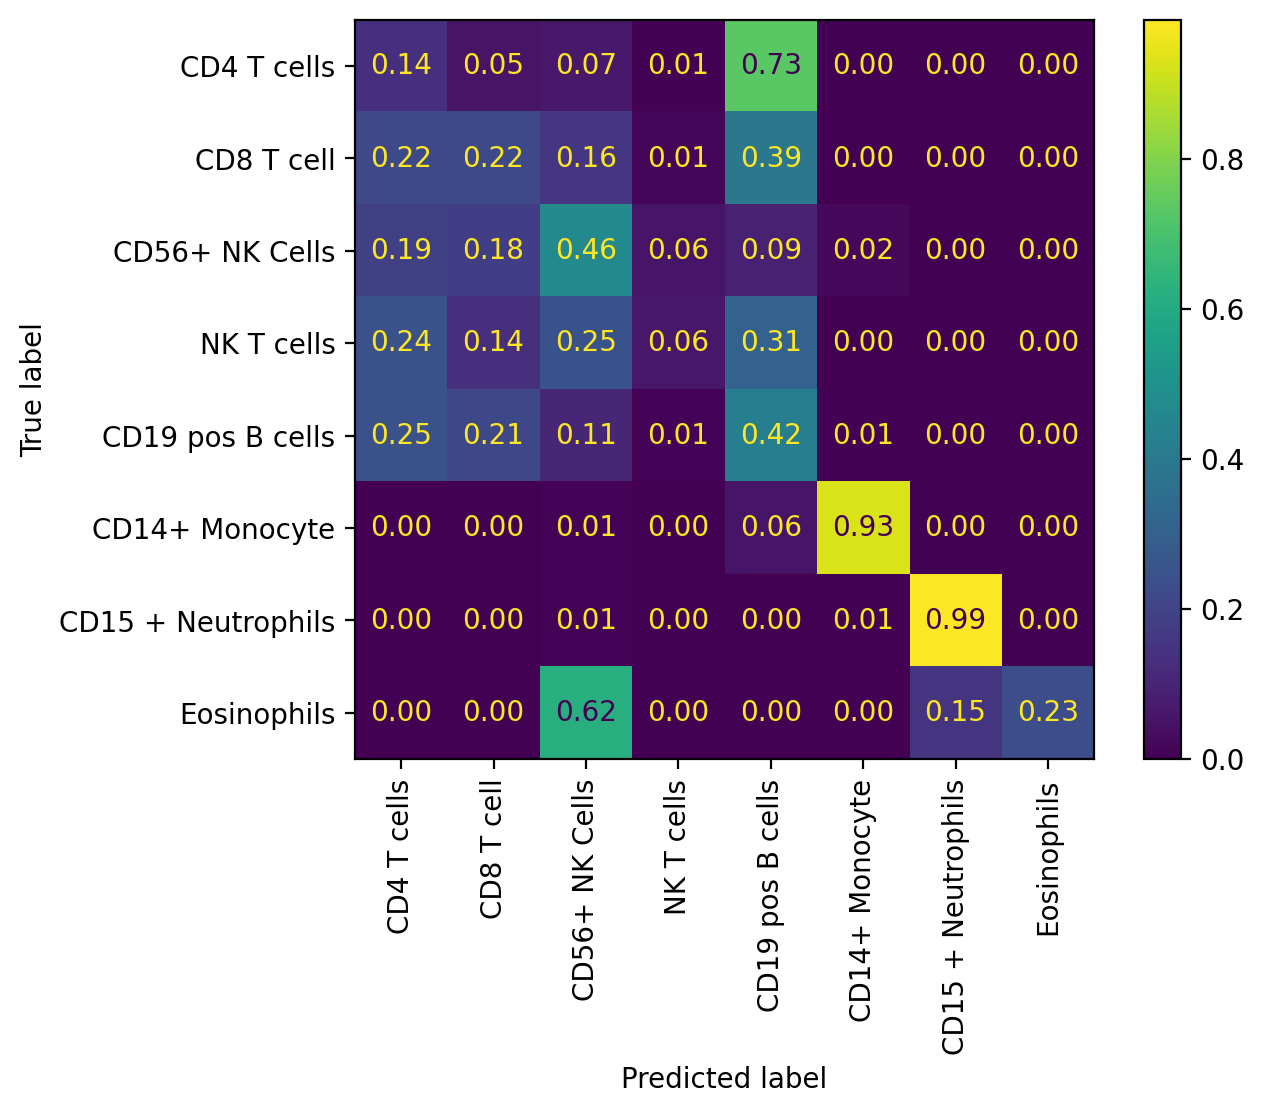

In [120]:
preds = []
true = []

for estimator, (_, test_index) in zip(result_outer["estimator"], outer_cv.split(X, y)):
    X_test, y_test = X_robust_mm.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true,
    preds,
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize="true",
    xticks_rotation="vertical",
    values_format=".2f",
    ax=ax,
)
# plt.savefig(output_confmat_full, bbox_inches="tight")
